In [19]:
# Tratamiento de datos
# ==============================================================================
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
import seaborn as sns
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
import splitfolders
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import class_weight

# Tratamiento de imágenes
# ==============================================================================
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import regularizers  
from keras import backend as K
from keras import layers
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, History  
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mobile Spectrophotometry
https://plantvillage.psu.edu/projects

# Introducción

Contamos con datos etiquetados, por lo que aplicaremos un modelo de _supervised learning_, de clasificación (diagnóstico de enfermedad de la planta de maíz). por tanto, nuestra target será un conjunto de valores discretos.

# 1. Procesamiento de datos

In [20]:
# Separamos en train y en test

# Dividimos los datos en train y test
# splitfolders.ratio(path, output="output", seed=42, ratio=(.8, .2), move=True) 

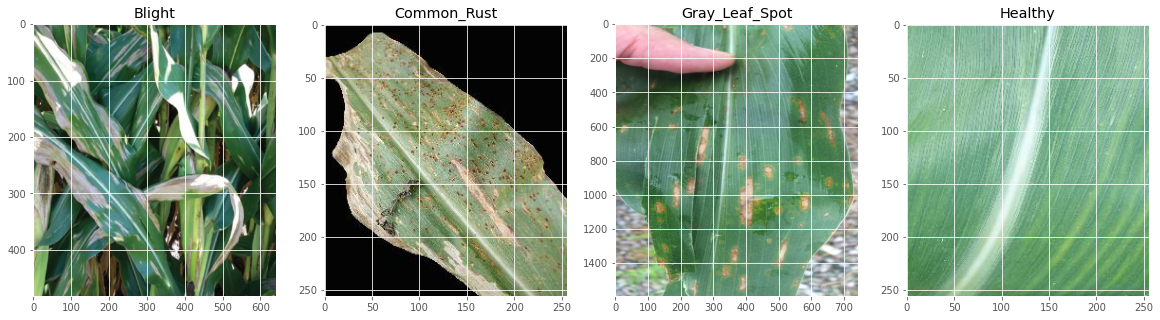

In [21]:
path_train = '../data/processed/train'
path_test = '../data/processed/val'
tipos = os.listdir(path_train)

# Vamos a mostrar imágenes aleatorias de cada una de las carpetas:
def mostrar_imagen_de_cada_tipo(path, introduce_un_numero):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axes.flatten()):
        # plotting all 4 images on the same figure
        image_path = os.listdir(path + '/' + tipos[i])[introduce_un_numero]
        ax.title.set_text(tipos[i])
        ax.imshow(cv2.imread(path + '/' + tipos[i] + '/' + image_path)[:,:,::-1], aspect='auto')    
    plt.show()

mostrar_imagen_de_cada_tipo(path_train, 1)

### Vamos a crear __'X'__ e __'y'__ a la vez que establecemos dimensiones a las imágenes

Intentar entrenar el modelo requiere de mucha memoria que no tenemos, por lo que es necesario dividir el proceso de entrenamiento en bloques (o batchs, en inglés) de menor tamaño de imágenes.

Es necesario poner cada imagen en una misma dimensión. Escalaremos la resolución de las imágenes para que sean de 224x224 pero, si vemos las imágenes originales, son mayores (y diferentes entre sí). Pues bien, vamos a definir el generador de imágenes de entrenamiento usando la clase ImageDataGenerator.

Podemos observar que el tamaño de las imágenes varía de imagen en imagen. Por ende, debemos regularizarlo.

In [22]:
# Definimos las dimensiones de las imágenes
img_width, img_height = 224, 224


# Tranformaciones
def define_x_y(img_folder):
   
    X = list()
    y = list()

   # Iteramos en el directorio, para cada una de las carpetas clasificadoras, 
    for i in os.listdir(img_folder):
        new_path = img_folder + '/' + i
        for j in os.listdir(new_path): # Iteramos para alcanzar cada una de las imágenes en cada directorio, y pasarlo a un array
            image_path= new_path + '/' + j # path de cada imagen
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB) # Read the image file from the folder and convert it to the right color format.
            image=cv2.resize(image, (img_width, img_height),interpolation = cv2.INTER_AREA) # Resize the image based on the input dimension required for the model
            image=np.array(image)
            image = image.astype('float32') # Convert the image to a Numpy array with float32 as the datatype
            image /= 255 # Normalizamos la imagen a valores entre 0 y 1 (por defecto van de 0 a 255), ayudará al modelo
            X.append(image)
            y.append(i)
    
    return X, y


# Definimos el path del directorio y creamos dataset
X_train, y_train = define_x_y(path_train)
X_test, y_test = define_x_y(path_test)

# Como habrás notado, tanto en X_train como en X_test hemos escalado el rango del contenido de los pixeles para que vayan de 0 a 1

### Convertimos las variables categóricas en numéricas

Creamos un diccionario, y convertimos la variable target en valores numéricos (definidos previamente en el diccionario)

In [23]:
target_dict_train ={k: v for v, k in enumerate(np.unique(y_train))}
target_dict_test ={k: v for v, k in enumerate(np.unique(y_test))}
target_dict_test

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

In [24]:
y_train =  [target_dict_train[y_train[i]] for i in range(len(y_train))]
y_test =  [target_dict_test[y_test[i]] for i in range(len(y_test))]

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# 2. Exploración de datos

## Target

Al ser un problema de ML de clasificación, debemos procurar que nuestros datos en train estén balanceados. Vamos a comprobarlo

In [26]:
def contar_imagenes(path, classes):
    class_count = []
    for i in classes:
        class_count.append(len(os.listdir(path + '/' + i)))
        
    df = pd.DataFrame(columns = ["Class_Name", "No of Images"])
    df['Class_Name'] = classes
    df["No of Images"] = class_count
    return df

In [27]:
summary_y_train = contar_imagenes(path_train, tipos)

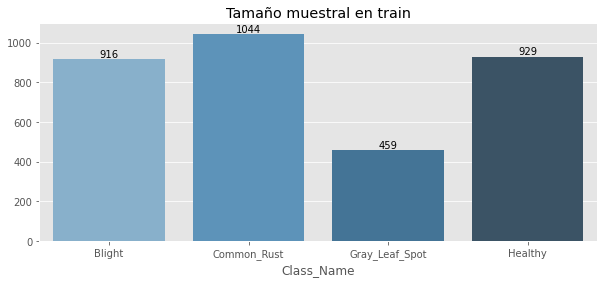

In [28]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=summary_y_train.iloc[:,0], y=summary_y_train.iloc[:,1], palette='Blues_d')
plt.title('Tamaño muestral en train')
plt.ylabel('', fontsize=18)
ax.bar_label(ax.containers[0]);

Vemos que el target está desbalanceado ligeramente

Para lograr un modelo que genelarice bien, __es fundamental compensar este desequilibrio__. De lo contrario, un modelo de ML tenderá a ignorar las muestras minoritarias, y por tanto tener un rendimiento menor cuando haya que etiquetarlas.

En este caso, los datos están desproporcionados ligeramente, especialemnte contamos con una minoría clara: 'Gray-Leaf_Spot'. Aplicaremos pesos si mejora el rendimiento de nuestro modelo.

## Comprensión de variables

Al ser un ejercicio de clasificación de imágenes, cada una de las dimensiones de cada imágen será una variable.

In [29]:
# Dimensiones: (nº total de muestras, altura, anchura, capas por píxel)
print(np.shape(X_train))
print(np.shape(y_train))

(3348, 224, 224, 3)
(3348, 1)


# 3. Definición del modelo y de las métricas

Respecto al modelo, probaremos con __redes neuronales__ por ser el tipo de modelos que mejor se justa a la detección de imágenes. Las redes neuronales son conocidas por su nomnbre en inglés: _CNN_ (Convolution Neural Networks).

- Una _convolución_ es simplemente una aplicación de un filtro a las imágenes que le pasemos. Los valores del filtro son pesos. Cuando aplicamos estos pesos de forma repetida a varios _inputs_, entonces, el modelo aprende y es capaz de detectar características específicas en las imágenes (_feature maps_).
- Como las capas convulacionales son sensibiles a la localización específica de las características aprendidas en cada imagen, el modelo aborda este problema tomando estas características fuera del _feature maps_ por medio de parches, los cuales se llaman  _pooling layers_. En definitiva, para identificar patrones relacionados con cada diferente tipo de clasificación, hay cuatro capas: imagen en sí, capa convulacional, no linearidad, y un parche llamado _pooling layer_.

Necesidades del modelo CNN:
- Que las imágenes estén expresadas en 3D en este orden: [rows, columns, channels]
- Si los valores de los píxeles están escalados (por defecto van de 0-255) ayudará bastante

In [30]:
# Comprobamos cómo está expresado cada pixel (hacemos tres slicings: 1. categoría target a la que pertenece, 2. imagen, 3. pixel):
X_train[0][0][0]

array([0.11372549, 0.34117648, 0.3019608 ], dtype=float32)

El modelo __Sequential__ es la forma más fácil de construir un modelo en Keras, una interfaz para la librería TensorFlow. Con este modelo iremos capa por capa, agregándolas mediante la función 'add()'.

In [31]:
# 2D Convolutional Neural Network
'''En convulaciones 2D, es recomendable que previamente se haya procesado la imagen en escala de grises (una profundidad). 
No obstante, los datos están a color (tres profundidades), por lo que tendremos que aplicar 3 filtros tridimensionales. 
Del mismo modo, se aplicarán tres convulaciones en lugar de una.'''

#Definición de un modelo sequencial con tres capas
model = Sequential()
input_shape=(224, 224, 3) # (height, width, depth)
chanDim = -1
init="he_normal"
categorias_a_predecir = 4 
reg = regularizers.l2(0.0005) # método de regularización

# Data augmentation (solo aplica durante las llamadas a Model.fit, y no en Model.evaluate o en Model.predict)
Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Añadimos cada capa al modelo secuencial
model.add(Conv2D(16, kernel_size=(7,7), strides=(2, 2), padding='valid', # Aplicamos strides evitando utilizar pooling
            kernel_initializer=init, kernel_regularizer=reg,
			input_shape=input_shape)) # Indicamos las dimensiones, para que construya a partir de ahí

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 32 filtros (3,3)
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg)) 
model.add(BatchNormalization(axis=chanDim)) # Estabiliza el training., pero hace más pesado y largo el proceso
model.add(Conv2D(32, kernel_size=(3,3), strides=(2, 2), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg)) # Aprenderá 32 filtros
model.add(BatchNormalization(axis=chanDim)) # Estabiliza el training., pero hace más pesado y largo el proceso
model.add(Dropout(0.25)) # ayuda a generalizar mejor

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 64 filtros (3,3)
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, kernel_size=(3,3), strides=(2, 2), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 128 filtros (3,3)
keras.layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same')
model.add(BatchNormalization(axis=chanDim))
keras.layers.Conv2D(128,kernel_size=(1,1), strides=(2, 2),activation='relu', padding='same')
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# Fully-conected layers: copila todas las capas para mostrar un resultado único
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init)) # una capa con 512 nodos se añade al modelo
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# softmax classifier: para predicciones multi-clase
model.add(Dense(categorias_a_predecir))
model.add(Activation("softmax")) # el output serán las predicciones

# Más info sobre Conv2D: https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

Para componer el modelo, indicaremostres campos:

- __Optimizador__: Utilizamores el optimizador __Adam__, ya que según Kingma et al., 2014 este método es _"computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters"._
 
- __Función de pérdidas__: Utilizaremos el __'Sparse categorical cross entropy'__, muy común para los modelos de clasificación multi-clase. Las funciones de pérdidas (loss functions) muestran cuánto se desvían las estimaciones de su valor real.

- __Métrica__: Utilizamos la métrica __Recall__, la cual muestra el porcentaje de positivos reales que se clasificaron correctamente. Como tratamos de diagnosticar qué plantas de maíz están enfermas, entonces, es de vital importancia identificar bien a todas las que sí que lo estén, y reducir el error de que no queden clasificadas como enfermas. Como segunda métrica decisiva, utilizaremos el F2 score.

In [32]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4. Entrenamiento del modelo

In [33]:
# fit the model
model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=2)

Epoch 1/11
27/27 - 101s - loss: 0.9520 - accuracy: 0.7897 - 101s/epoch - 4s/step
Epoch 2/11
27/27 - 103s - loss: 0.5303 - accuracy: 0.8793 - 103s/epoch - 4s/step
Epoch 3/11
27/27 - 103s - loss: 0.4134 - accuracy: 0.9238 - 103s/epoch - 4s/step
Epoch 4/11
27/27 - 102s - loss: 0.3813 - accuracy: 0.9379 - 102s/epoch - 4s/step
Epoch 5/11
27/27 - 101s - loss: 0.3593 - accuracy: 0.9477 - 101s/epoch - 4s/step
Epoch 6/11
27/27 - 7481s - loss: 0.2788 - accuracy: 0.9746 - 7481s/epoch - 277s/step
Epoch 7/11
27/27 - 86s - loss: 0.2581 - accuracy: 0.9791 - 86s/epoch - 3s/step
Epoch 8/11
27/27 - 105s - loss: 0.2460 - accuracy: 0.9872 - 105s/epoch - 4s/step
Epoch 9/11
27/27 - 221s - loss: 0.2214 - accuracy: 0.9940 - 221s/epoch - 8s/step
Epoch 10/11
27/27 - 156s - loss: 0.2216 - accuracy: 0.9934 - 156s/epoch - 6s/step
Epoch 11/11
27/27 - 250s - loss: 0.2087 - accuracy: 0.9949 - 250s/epoch - 9s/step


In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 109, 109, 16)      2368      
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_14 (Bat  (None, 109, 109, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 55, 55, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 55, 55, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 55, 55, 32)       

# 5. Evaluación del modelo

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(baseline_history)

In [35]:
# from keras.callbacks import History 

# history = History()

# Más info: https://stackoverflow.com/questions/36952763/how-to-return-history-of-validation-loss-in-keras

In [36]:
# evaluación del modelo
loss = model.evaluate(X_train, y_train, verbose=2)

105/105 - 41s - loss: 0.2774 - accuracy: 0.9642 - 41s/epoch - 389ms/step


In [37]:
loss = model.evaluate(X_test, y_test, verbose=2)

27/27 - 4s - loss: 0.7118 - accuracy: 0.8595 - 4s/epoch - 148ms/step


# Guardamos el modelo

In [42]:
# Vamos a guardar nuestro modelo
if 'model_v2' not in os.listdir():
    model.save("model_v2")


# Más info: https://www.tensorflow.org/guide/keras/save_and_serialize

In [228]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model("model_v0")

# Aportes de este modelo

Respecto a 'model_vo', este modelo incluye 'data_augmentation', el cual ha aumentado el _accuracy_ en test del 44% al 86% (con epoch=11)